In [1]:
# Imports
from torch.nn.functional import binary_cross_entropy
from torch.utils.data import DataLoader
import esm
from torch import nn
import numpy as np
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
import seaborn as sns
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
# Accessing GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Loading in data
train_data = pd.read_csv('Data/train_data.csv')
val_data = pd.read_csv('Data/val_data.csv')
test_data = pd.read_csv('Data/test_data.csv')

In [4]:
# Encoding sequences
from preprocessing import aa_encode

# Removing unknown amino acids
unknown_aa = ['O', 'U', 'X']

# Create a mask to identify sequences containing any of the unknown residue symbols
train_mask = train_data['sequence'].apply(lambda seq: any(aa in unknown_aa for aa in seq))
val_mask = val_data['sequence'].apply(lambda seq: any(aa in unknown_aa for aa in seq))
test_mask = test_data['sequence'].apply(lambda seq: any(aa in unknown_aa for aa in seq))

# Filter the data to keep only the rows where the sequence does not contain any unknown residue symbols
train_data = train_data[train_mask == False]
val_data = val_data[val_mask == False]
test_data = test_data[test_mask == False]

In [5]:
from ESM2Dataset import ESM2Dataset
from preprocessing import collate_fn

# Load ESM alphabet
esm_model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()

In [6]:
# Create dataset
train_dataset = ESM2Dataset(train_data, batch_converter)
val_dataset = ESM2Dataset(val_data, batch_converter)
test_dataset = ESM2Dataset(test_data, batch_converter)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [7]:
def train_model(model, train_loader, val_loader, epochs, patience, device):
    """
    Trains the model with the given train and validation dataloaders.
    Implements early stopping to avoid overfitting.
    """
    
    # Move model to device
    model.to(device)

    # Define the criterion and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) # 0.00001

    # Early stopping configuration
    early_stop_counter = 0
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for sequences, attention_masks, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            # Send data to device
            sequences = sequences.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device).float()
            labels = labels.unsqueeze(1)  # Shape: [batch_size, 1]
            
            # Forward pass
            optimizer.zero_grad()
            # Only taking outputs and not attention maps
            outputs = model(sequences, attention_mask=attention_masks)

            # Compute the loss
            loss = criterion(outputs, labels)
            loss.backward()

            # Optimizer step
            optimizer.step()

            # Accumulate the training loss
            train_loss += loss.item()

        # Average the training loss across all batches
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for sequences, attention_masks, labels in tqdm(val_loader, desc="Validating"):
                # Send validation data to the device
                sequences = sequences.to(device)
                attention_masks = attention_masks.to(device)
                labels = labels.to(device).float()
                labels = labels.unsqueeze(1)  # Shape: [batch_size, 1]

                # Forward pass
                outputs = model(sequences, attention_mask=attention_masks)

                # Compute the loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Average validation loss
        avg_val_loss = val_loss / len(val_loader)

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Print metrics for the epoch
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

        # Check for early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping triggered. No improvement in validation loss for {patience} epochs.")
            break

In [8]:
from ESM2Classifier import ESM2Classifier
model = ESM2Classifier(esm_model = esm_model, num_heads=8, num_layers=3, dropout=0.2)
train_model(model, train_loader, val_loader, epochs=30, patience=3, device=device)

/home/jmontour15/dl_final/ESM2Dataset.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens = torch.tensor(tokens, dtype=torch.long).squeeze(0)
/home/jmontour15/dl_final/preprocessing.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_tensors = [torch.tensor(tokens, dtype=torch.long) for tokens in tokens_list]


alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.18it/s]

Epoch 1 | Train Loss: 0.3949 | Validation Loss: 0.3361




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.10it/s]

Epoch 2 | Train Loss: 0.3021 | Validation Loss: 0.3261




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.12it/s]

Epoch 3 | Train Loss: 0.2887 | Validation Loss: 0.3241




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.15it/s]

Epoch 4 | Train Loss: 0.2594 | Validation Loss: 0.3361




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.22it/s]

Epoch 5 | Train Loss: 0.2311 | Validation Loss: 0.2821




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.20it/s]

Epoch 6 | Train Loss: 0.1992 | Validation Loss: 0.2881




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.21it/s]

Epoch 7 | Train Loss: 0.1947 | Validation Loss: 0.2681




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.13it/s]

Epoch 8 | Train Loss: 0.1813 | Validation Loss: 0.2379




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.17it/s]

Epoch 9 | Train Loss: 0.1609 | Validation Loss: 0.2589




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.18it/s]

Epoch 10 | Train Loss: 0.1540 | Validation Loss: 0.2361




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.21it/s]

Epoch 11 | Train Loss: 0.1366 | Validation Loss: 0.2397




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.15it/s]

Epoch 12 | Train Loss: 0.1195 | Validation Loss: 0.2809




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.01it/s]

Epoch 13 | Train Loss: 0.1188 | Validation Loss: 0.2312




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.18it/s]

Epoch 14 | Train Loss: 0.1124 | Validation Loss: 0.2318




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.13it/s]

Epoch 15 | Train Loss: 0.1050 | Validation Loss: 0.2820



Validating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:17<00:00, 12.14it/s]

Epoch 16 | Train Loss: 0.0917 | Validation Loss: 0.2527
Early stopping triggered. No improvement in validation loss for 3 epochs.


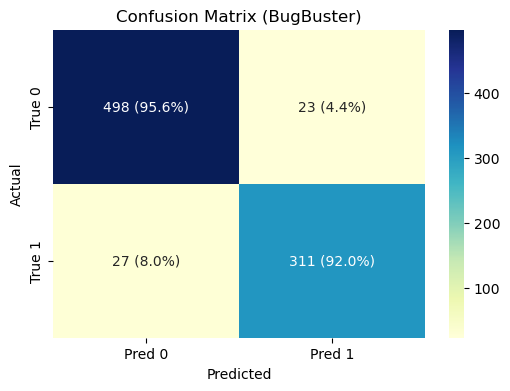

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       521
           1       0.93      0.92      0.93       338

    accuracy                           0.94       859
   macro avg       0.94      0.94      0.94       859
weighted avg       0.94      0.94      0.94       859



In [9]:
from sklearn.metrics import confusion_matrix, classification_report

# Set the model to evaluation mode
model.eval()  

y_true = []
y_pred = []

# Iterate through the test_loader to get true labels and predictions
with torch.no_grad():
    for sequences, attention_masks, labels in test_loader:
        sequences, attention_masks, labels = sequences.to(device), attention_masks.to(device), labels.to(device)
        
        # Forward pass to get predictions
        outputs = model(sequences, attention_mask=attention_masks)
        
        # Apply a threshold to get binary predictions (e.g., if output > 0.5, predict 1; else, predict 0)
        predicted = (outputs > 0.5).float()
        
        # Store true labels and predictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Combine total amounts and percentages
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        annot[i, j] = f"{cm[i, j]} ({cm_percentage[i, j]:.1f}%)"

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=annot, fmt='', cmap='YlGnBu', xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (BugBuster)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('Figures/ConfusionMatrix_BB.png')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))


In [10]:
# Get the first batch from the test loader
for batch_idx, (batch_tokens, attention_mask, labels) in enumerate(test_loader):
    if batch_idx == 0:  # Get the first batch
        # Move the batch to the correct device
        batch_tokens = batch_tokens.to(device)
        attention_masks = attention_mask.to(device)

        model.eval()

        # Reset attention maps before forward pass
        model.attention_maps = []

        # Register hook for attention collection
        collect_attention = True
        if collect_attention:
            for attention_layer in model.attention_layers:  # Use attention_layers here
                attention_layer.register_forward_hook(model.save_attention)

        # Perform a forward pass with attention map collection
        with torch.no_grad():
            logits, attention_maps = model(batch_tokens, attention_masks, collect_attention=True)

        # Check if attention maps were collected
        if attention_maps:
            first_batch_attention_maps = attention_maps[0]  # First batch's attention maps
            # Print attention maps shape (for debugging)
            print(f"Shape of attention maps for first batch: {first_batch_attention_maps.shape}")
        else:
            print("No attention maps collected.")
        
        break  # Stop after processing the first batch


Shape of attention maps for first sample: torch.Size([4, 386, 386])


/home/jmontour15/dl_final/ESM2Dataset.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens = torch.tensor(tokens, dtype=torch.long).squeeze(0)
/home/jmontour15/dl_final/preprocessing.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_tensors = [torch.tensor(tokens, dtype=torch.long) for tokens in tokens_list]


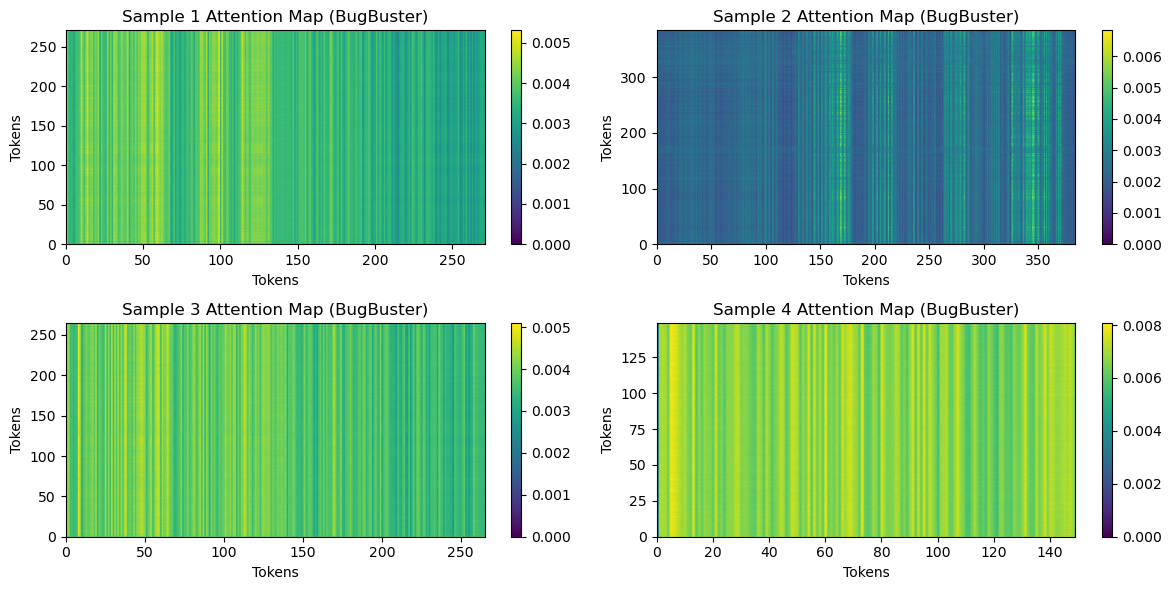

In [11]:
# Gather maps and masks, convert to numpy, and transfer to cpu for easy plotting
attention_maps = [first_batch_attention_maps[i].cpu().numpy() for i in range(4)]
attention_masks = attention_masks.cpu().numpy()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))  # Adjust figsize as needed

# Plot each attention map
for idx, ax in enumerate(axes.flat):
    # Get the number of valid tokens from the attention mask (sum of 1s)
    valid_token_count = attention_masks[idx].sum()
    
    # Plot the attention map
    im = ax.imshow(
        attention_maps[idx][:valid_token_count, :valid_token_count],  # Slice to include only valid tokens
        cmap='viridis', 
        aspect='auto'
    )
    ax.set_title(f"Sample {idx + 1} Attention Map (BugBuster)")
    
    # Set x-axis and y-axis labels
    ax.set_xlabel("Tokens")
    ax.set_ylabel("Tokens")
    ax.set_xlim(0, valid_token_count - 1)
    ax.set_ylim(0, valid_token_count - 1)
    
    # Add a colorbar for each subplot
    fig.colorbar(im, ax=ax, orientation='vertical')

plt.tight_layout()
plt.savefig('Figures/AttentionMaps_BB.png')
plt.show()